<a href="https://colab.research.google.com/github/DH2319765/lab_6_zonal_stat/blob/main/Lab6_Illinois_Aviskar_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1

In [2]:
#mount the google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np

In [4]:
!pip install rasterio geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 66.8 MB/s eta 0:00:00


In [65]:
#import Modules
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
#import source tiff file
src = rasterio.open('/content/drive/MyDrive/Geospatial_Analytics/lab-6/illinois_cdl.tif')

In [39]:
#import provided county data
county = gpd.read_file('/content/drive/MyDrive/Geospatial_Analytics/lab-6/cb_2018_us_county_20m/cb_2018_us_county_20m.shp')

In [40]:
#read the image file using rasterio - and no, I am not using Chatgpt
img = src.read()

In [41]:

#As Dr. Bhadra always says, " Always check the shape before doing anything"
img.shape


(1, 21548, 13317)

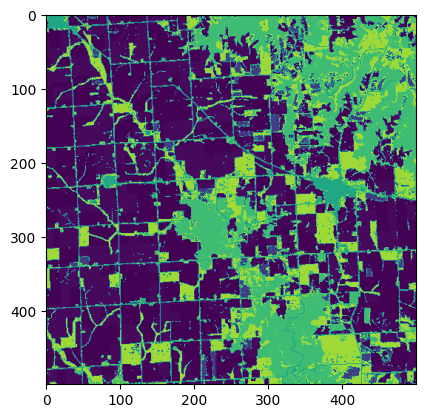

In [42]:
#lets laod the beautifl tiff file by taking the 282 data only from the source file
plt.imshow(img[0, :500, :500])

<Axes: >

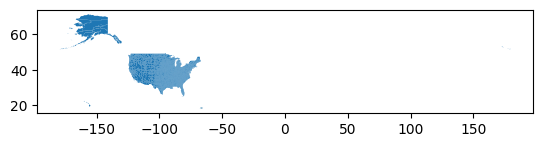

In [43]:
county.plot()

In [44]:
#load counties for il
il_county = county[county['STATEFP'] == '17']


<Axes: >

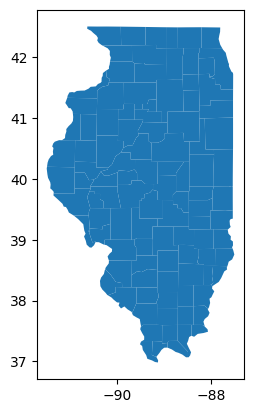

In [45]:
il_county.plot()
#Looking good

In [46]:
#Check the IL CRS
il_county.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [47]:
#Find the raster epsg code
raster_epsg= src.crs.to_epsg()

In [48]:
raster_epsg #what is the epsg code?

5070

In [49]:
# reproject the vounty shapefile to match the raster crs
il_county_proj = il_county.to_crs(f'EPSG: {raster_epsg}')

In [50]:
# reset the index
il_county_proj = il_county_proj.reset_index(drop=True)

In [51]:
#checking the data
il_county_proj.head(5)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,17,023,00424213,0500000US17023,17023,Clark,06,1298695036,8796711,"POLYGON ((679867.6 1857374.326, 684450.962 185..."
1,17,093,00424248,0500000US17093,17093,Kendall,06,829468028,5136619,"POLYGON ((610436.69 2103309.388, 626669.044 21..."
2,17,009,00424206,0500000US17009,17009,Brown,06,791704469,4139310,"POLYGON ((429604.031 1910180.838, 447972.441 1..."
3,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((434503.496 2018613.157, 463312.79 20..."
4,17,181,01785113,0500000US17181,17181,Union,06,1070856127,22502069,"POLYGON ((568160.225 1632819.248, 568428.378 1..."


In [52]:
from rasterio.mask import mask

In [53]:
out_image, out_transform = rasterio.mask.mask(dataset = src, shapes =[ il_county_proj.loc[0,'geometry']], crop=True)

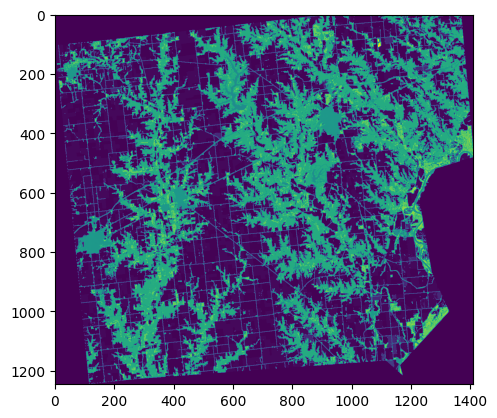

In [54]:
plt.imshow(out_image[0])

In [55]:
masked_arr = out_image[0, :, :]

In [56]:
masked_arr.shape

(1246, 1411)

In [57]:
corn_mask = (masked_arr == 1)*1
soy_mask = (masked_arr == 5)*1


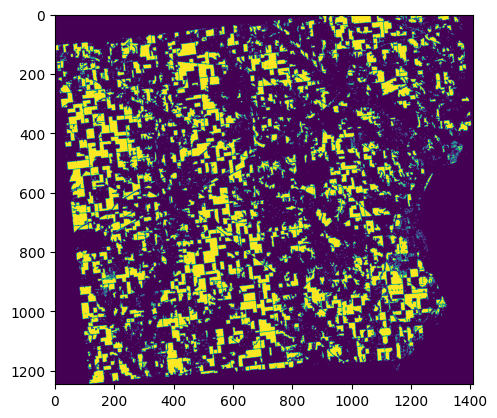

In [58]:
plt.imshow(corn_mask)

In [59]:
np.count_nonzero(corn_mask)*900

379951200

In [60]:
np.count_nonzero(soy_mask)*900

370400400

In [63]:
# create empty lists to hold masked information
corn_areas = []
soy_areas = []
county_fps = []

# run for loop
for i, row in il_county_proj.iterrows():
  # mask the image based on county geometry
  out_image, out_transform = rasterio.mask.mask(
      dataset=src,
      shapes=[row['geometry']],
      crop=True
  )
  # take only the first band
  masked_arr = out_image[0, :, :]
  # find the corn and soy pixels, 1s true, 0s false
  corn_mask = (masked_arr == 1) * 1
  soy_mask = (masked_arr == 5) * 1
  # calculate area by multiplying with 900 (30*30) sq m
  corn_area = np.count_nonzero(corn_mask) * 900
  soy_area = np.count_nonzero(soy_mask) * 900

  # append it to the list
  corn_areas.append(corn_area)
  soy_areas.append(soy_area)
  county_fps.append(row['COUNTYFP'])

In [66]:
crop_area = pd.DataFrame(
    {
        'county_fp': county_fps,
        'corn_area': corn_areas,
        'soy_area': soy_areas
    }
)

In [67]:
il_crop_area_shp = pd.merge(
    il_county_proj,
    crop_area,
    left_on='COUNTYFP',
    right_on='county_fp'
)

In [68]:
# let's check it
il_crop_area_shp

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,county_fp,corn_area,soy_area
0,17,023,00424213,0500000US17023,17023,Clark,06,1298695036,8796711,"POLYGON ((679867.6 1857374.326, 684450.962 185...",023,379951200,370400400
1,17,093,00424248,0500000US17093,17093,Kendall,06,829468028,5136619,"POLYGON ((610436.69 2103309.388, 626669.044 21...",093,302125500,238187700
2,17,009,00424206,0500000US17009,17009,Brown,06,791704469,4139310,"POLYGON ((429604.031 1910180.838, 447972.441 1...",009,154169100,127105200
3,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((434503.496 2018613.157, 463312.79 20...",187,586556100,484054200
4,17,181,01785113,0500000US17181,17181,Union,06,1070856127,22502069,"POLYGON ((568160.225 1632819.248, 568428.378 1...",181,46452600,119649600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,17,001,00424202,0500000US17001,17001,Adams,06,2214804824,41767689,"POLYGON ((379070.258 1918367.149, 429199.191 1...",001,601100100,523474200
98,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((542119.643 1754199.825, 551733.276 1...",027,384759900,280682100
99,17,019,00424211,0500000US17019,17019,Champaign,06,2579909092,6099477,"POLYGON ((635855.481 1928136.789, 634846.756 1...",019,1055686500,1037918700
100,17,049,00424226,0500000US17049,17049,Effingham,06,1239970330,3183217,"POLYGON ((614893.796 1822435.888, 643427.411 1...",049,337799700,350055900


In [69]:
il_crop_area_shp.to_file('/content/drive/MyDrive/Geospatial_Analytics/lab-6/io_crop_area.shp') ##Export ther shapefile

## Task 2 Completed in VS Code to upload to github repo
